In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization,Add,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LeakyReLU, ReLU, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import layers

In [3]:
def UNet(pretrained_weights = None,input_size = (128,128,3)):
    inp = Input(input_size)

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(3, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inp, outputs=[conv10])

    return model

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_24[0][0]']              
                                )                                                           

In [ ]:
def identity_loss(y_true, y_pred):
  loss = tf.reduce_mean(tf.abs(y_true - y_pred))
  return loss

In [5]:
import numpy as np
from glob import glob
from PIL import Image

data_path = glob("good/*.png")
batch_size = 32


dataset = list()

for data in data_path:
  image = Image.open(data)
  image = image.resize((128, 128))
  image = np.array(image) / 255.0

  dataset.append(image)

train_dataset = tf.data.Dataset.from_tensor_slices((dataset, dataset)).shuffle(buffer_size=2372).batch(batch_size)

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [6]:
model = UNet()
model.compile(optimizer=Adam(lr=3e-4), loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
model.fit(train_dataset, epochs=100, batch_size=batch_size, shuffle=True)

Epoch 1/100
6/6 [==============================] - 28s 1s/step - loss: 1.0206
Epoch 2/100
6/6 [==============================] - 3s 449ms/step - loss: 0.6477
Epoch 3/100
6/6 [==============================] - 3s 451ms/step - loss: 0.6340
Epoch 4/100
6/6 [==============================] - 3s 451ms/step - loss: 0.6405
Epoch 5/100
6/6 [==============================] - 3s 450ms/step - loss: 0.6255
Epoch 6/100
6/6 [==============================] - 3s 453ms/step - loss: 0.6193
Epoch 7/100
6/6 [==============================] - 3s 452ms/step - loss: 0.6146
Epoch 8/100
6/6 [==============================] - 3s 454ms/step - loss: 0.6226
Epoch 9/100
6/6 [==============================] - 3s 459ms/step - loss: 0.6194
Epoch 10/100
6/6 [==============================] - 3s 458ms/step - loss: 0.6163
Epoch 11/100
6/6 [==============================] - 3s 460ms/step - loss: 0.6135
Epoch 12/100
6/6 [==============================] - 3s 455ms/step - loss: 0.6125
Epoch 13/100
6/6 [=====================

In [11]:
model.save("u-net.h5")

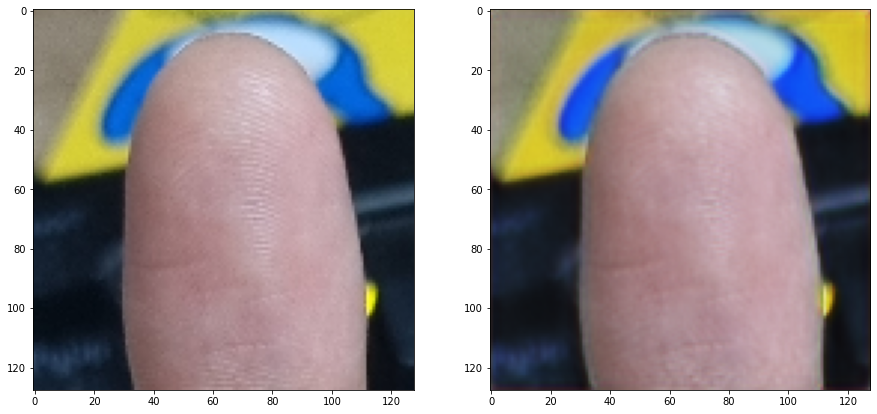

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

sample_images = glob('index.png')

for sample_image in sample_images:
  f, ax = plt.subplots(1, 2)
  f.set_figheight(15)
  f.set_figwidth(15)
  img = np.array(Image.open(sample_image))
  img = cv2.resize(img, (128,128)) / 255.0
  ax[0].imshow(img)
  ax[1].imshow(model.predict(img.reshape((1, 128, 128, 3))).reshape((128,128,3)))
  plt.show()